<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/main/start_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow
import pandas as pd
import time
import numpy as np
import statistics

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Read Data

In [27]:
df = pd.read_csv('./features_30_sec.csv')

In [28]:
df['label'].value_counts()

reggae       100
blues        100
jazz         100
rock         100
pop          100
classical    100
disco        100
hiphop       100
metal        100
country      100
Name: label, dtype: int64

#Question 1


In [29]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset_question1(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [30]:
X_train, y_train, X_test, y_test = prepare_dataset_question1(df, columns_to_drop, test_size=0.3, random_state=0)


In [31]:
def build_model(total_classes,input_shape,hidden_layer_neurons=16,hidden_layers=1,need_drop_out=True,dropout_probability=0.3,optimizer='adam'):

  model=tf.keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  for i in range(hidden_layers):
    model.add(keras.layers.Dense(hidden_layer_neurons, activation="relu"))
    if(need_drop_out):
      model.add(keras.layers.Dropout(dropout_probability))
  model.add(keras.layers.Dense(total_classes, activation='softmax'))
  model.compile(optimizer=optimizer,metrics=['accuracy'],loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

def train_model(model,epochs,X_train,y_train,X_test,y_test,batch_size=1,callbacks=[]):

  history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),callbacks=callbacks)
  return history


In [32]:
history={}
model=build_model(10,X_train[0].shape)
history['question-1']=train_model(model,50,X_train,y_train,X_test,y_test)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


700/700 [==============================] - 1s 2ms/step - loss: 2.2437 - accuracy: 0.2429 - val_loss: 1.7824 - val_accuracy: 0.4200
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.7141 - accuracy: 0.3814 - val_loss: 1.5007 - val_accuracy: 0.5100
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.5402 - accuracy: 0.4371 - val_loss: 1.3745 - val_accuracy: 0.5300
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 1.4194 - accuracy: 0.4729 - val_loss: 1.2830 - val_accuracy: 0.5600
Epoch 5/50
700/700 [==============================] - 1s 1ms/step - loss: 1.2606 - accuracy: 0.5414 - val_loss: 1.1997 - val_accuracy: 0.6133
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 1.2285 - accuracy: 0.5657 - val_loss: 1.1795 - val_accuracy: 0.5967
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 1.1836 - accuracy: 0.5571 - val_loss: 1.1316 - val_accuracy: 0.6267
Epoch 8/50
700/70

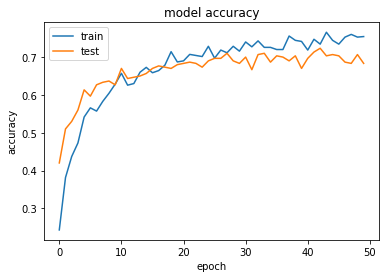

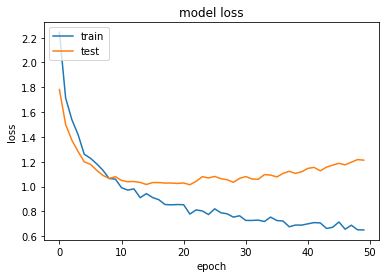

In [33]:
plt.plot(history['question-1'].history['accuracy'])
plt.plot(history['question-1'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['question-1'].history['loss'])
plt.plot(history['question-1'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Question 2

In [34]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [35]:
n_splits=3
kf = KFold(n_splits=n_splits)

batch_sizes=[1,4,8,16,32,64]
total_classes=10
input_shape=X_train[0].shape
history={}
k_fold=1
epochs=50
epoch_times={}

for element in batch_sizes:

  epoch_times[element]=[]

for train,test in kf.split(X_train):

  X_train_cross_validation , X_test_cross_validation = X_train[train] , X_train[test]
  y_train_cross_validation , y_test_cross_validation = y_train[train] , y_train[test]

  for batch_size in batch_sizes:
    print()
    print('Model for batch size ',batch_size, ' and fold ',k_fold)
    tf.keras.backend.clear_session()
    model=build_model(total_classes,input_shape)
    time_callback = TimeHistory()
    history[(batch_size,k_fold)] = train_model(model,epochs,X_train_cross_validation,y_train_cross_validation,X_test_cross_validation,y_test_cross_validation,batch_size,[time_callback])
    
    for element in time_callback.times:
      epoch_times[batch_size].append(element)

  k_fold+=1



Model for batch size  1  and fold  1
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


466/466 [==============================] - 1s 2ms/step - loss: 2.3155 - accuracy: 0.1695 - val_loss: 1.8671 - val_accuracy: 0.2949
Epoch 2/50
466/466 [==============================] - 1s 2ms/step - loss: 1.8410 - accuracy: 0.3197 - val_loss: 1.6022 - val_accuracy: 0.4487
Epoch 3/50
466/466 [==============================] - 1s 1ms/step - loss: 1.6273 - accuracy: 0.4056 - val_loss: 1.4548 - val_accuracy: 0.4744
Epoch 4/50
466/466 [==============================] - 1s 1ms/step - loss: 1.4922 - accuracy: 0.4657 - val_loss: 1.3597 - val_accuracy: 0.4915
Epoch 5/50
466/466 [==============================] - 1s 2ms/step - loss: 1.3934 - accuracy: 0.4936 - val_loss: 1.2831 - val_accuracy: 0.5299
Epoch 6/50
466/466 [==============================] - 1s 2ms/step - loss: 1.3180 - accuracy: 0.5000 - val_loss: 1.2362 - val_accuracy: 0.5641
Epoch 7/50
466/466 [==============================] - 1s 2ms/step - loss: 1.2770 - accuracy: 0.5300 - val_loss: 1.2067 - val_accuracy: 0.5897
Epoch 8/50
466/46

In [36]:
mean_cross_validation_accuracies=[]
for batch_size in batch_sizes:
  temp=[]

  for k_fold in range(1,4):
    temp.append(history[batch_size,k_fold].history['val_accuracy'])

  mean_accuracy=[0]*epochs

  for list1 in temp:
    for epoch in range(len(list1)):
      mean_accuracy[epoch]+=list1[epoch]
  
  for i in range(epochs):
    mean_accuracy[i]=mean_accuracy[i]/3
    
  mean_cross_validation_accuracies.append(mean_accuracy.copy())


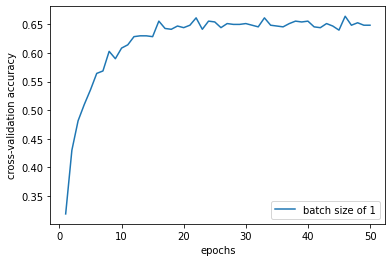

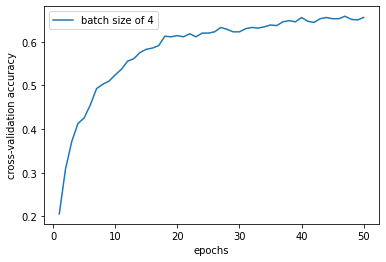

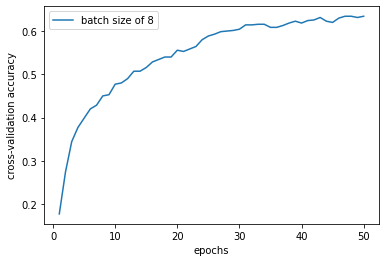

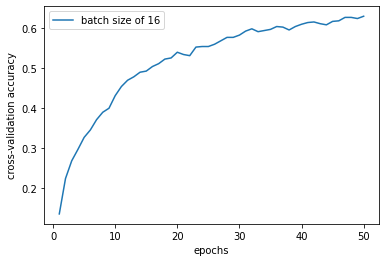

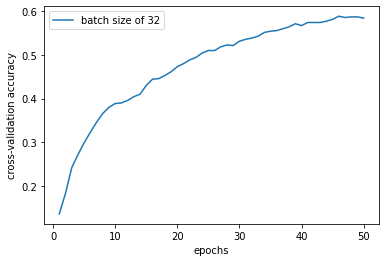

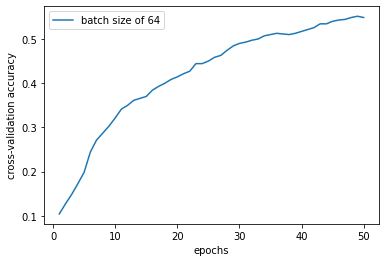

In [37]:
epoch_list=[(i+1) for i in range(epochs)]

for index in range(len(batch_sizes)):
  batch_size=batch_sizes[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.xlabel('epochs')
  plt.ylabel('cross-validation accuracy')
  plt.plot(epoch_list, mean_accuracy_list, label = 'batch size of '+str(batch_sizes[index]))
  plt.legend()
  plt.show()

In [38]:
median_epoch_times={}
for batch_size in epoch_times.keys():
  median_epoch_times[batch_size]=float("{:.2f}".format(statistics.median(epoch_times[batch_size])))
median_epoch_time_table=pd.DataFrame(median_epoch_times.items(),columns=['Batch_size','Mean_time'])

In [39]:
median_epoch_time_table.index = median_epoch_time_table.index + 1
median_epoch_time_table

,Batch_size,Mean_time
1,1,0.80
2,4,0.23
3,8,0.14
4,16,0.08
5,32,0.05
6,64,0.04


Model for optimal batch size  32
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


22/22 [==============================] - 0s 7ms/step - loss: 2.3576 - accuracy: 0.1429 - val_loss: 2.1737 - val_accuracy: 0.1933
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 2.1746 - accuracy: 0.2000 - val_loss: 2.0490 - val_accuracy: 0.2733
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 2.0463 - accuracy: 0.2429 - val_loss: 1.9568 - val_accuracy: 0.3300
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 1.9251 - accuracy: 0.3014 - val_loss: 1.8746 - val_accuracy: 0.3467
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 1.8644 - accuracy: 0.3343 - val_loss: 1.8087 - val_accuracy: 0.3767
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 1.7633 - accuracy: 0.3643 - val_loss: 1.7556 - val_accuracy: 0.3933
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 1.7309 - accuracy: 0.3886 - val_loss: 1.7010 - val_accuracy: 0.4133
Epoch 8/50
22/22 [=============

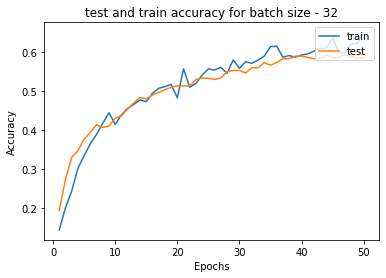

In [40]:
epoch_list=[(i+1) for i in range(epochs)]
optimal_batch_size = 32
print('Model for optimal batch size ',optimal_batch_size)
tf.keras.backend.clear_session()
model=build_model(total_classes,input_shape)
time_callback = TimeHistory()
history['optimal_batch_size_model'] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size,[time_callback])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('test and train accuracy for batch size - '+str(optimal_batch_size))
plt.plot(epoch_list,history['optimal_batch_size_model'].history['accuracy'],label='train accuracy')
plt.plot(epoch_list,history['optimal_batch_size_model'].history['val_accuracy'],label='test accuracy')
plt.legend(['train','test'] , loc='upper right')


#Question 3


In [41]:
hidden_layer_neuron_list=[8, 16, 32, 64]
k_fold = 1
for train,test in kf.split(X_train):

  X_train_cross_validation , X_test_cross_validation = X_train[train] , X_train[test]
  y_train_cross_validation , y_test_cross_validation = y_train[train] , y_train[test]

  for hidden_layer_neurons in hidden_layer_neuron_list:

    print()
    print('Model for ',hidden_layer_neurons, ' neurons and fold ',k_fold)
    tf.keras.backend.clear_session()
    model=build_model(total_classes,input_shape,hidden_layer_neurons)
    history[(hidden_layer_neurons,k_fold)] = train_model(model,epochs,X_train_cross_validation,y_train_cross_validation,X_test_cross_validation,y_test_cross_validation,optimal_batch_size,[time_callback])

  k_fold+=1


Model for  8  neurons and fold  1
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


15/15 [==============================] - 0s 11ms/step - loss: 2.6781 - accuracy: 0.0901 - val_loss: 2.5008 - val_accuracy: 0.1154
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 2.5091 - accuracy: 0.1288 - val_loss: 2.3917 - val_accuracy: 0.1325
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 2.4458 - accuracy: 0.1395 - val_loss: 2.2987 - val_accuracy: 0.1496
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 2.3399 - accuracy: 0.1373 - val_loss: 2.2230 - val_accuracy: 0.1667
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 2.2766 - accuracy: 0.1631 - val_loss: 2.1643 - val_accuracy: 0.1795
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 2.1979 - accuracy: 0.2039 - val_loss: 2.1135 - val_accuracy: 0.1966
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 2.1173 - accuracy: 0.2146 - val_loss: 2.0725 - val_accuracy: 0.2350
Epoch 8/50
15/15 [============

In [42]:
mean_cross_validation_accuracies=[]
for hidden_layer_neurons in hidden_layer_neuron_list:
  temp=[]
  for key in history.keys():
    if(key[0]==hidden_layer_neurons):
      temp.append(history[key].history['val_accuracy'])
  mean_accuracy=[0]*epochs
  for element in temp:
    for epoch in range(epochs):
      mean_accuracy[epoch]+=element[epoch]
  for epoch in range(epochs):
    mean_accuracy[epoch]=mean_accuracy[epoch]/n_splits
  mean_cross_validation_accuracies.append(mean_accuracy)

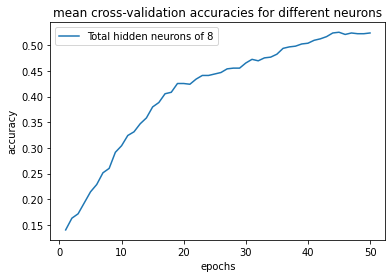

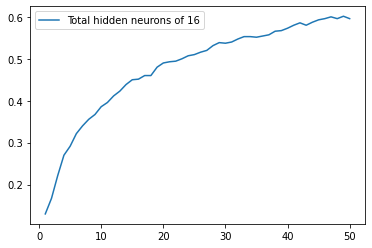

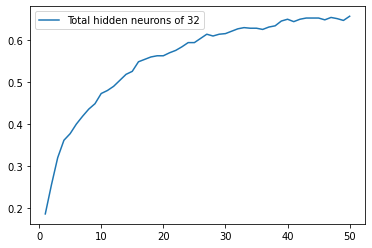

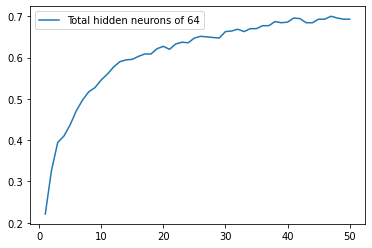

In [43]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('mean cross-validation accuracies for different neurons')
for index in range(len(hidden_layer_neuron_list)):
  hidden_layer_neurons=hidden_layer_neuron_list[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.plot(epoch_list, mean_accuracy_list, label = 'Total hidden neurons of '+str(hidden_layer_neuron_list[index]))
  plt.legend()
  plt.show()

Model for optimal neurons  64
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


22/22 [==============================] - 0s 8ms/step - loss: 2.5478 - accuracy: 0.1586 - val_loss: 2.1136 - val_accuracy: 0.2633
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 2.0306 - accuracy: 0.3129 - val_loss: 1.8302 - val_accuracy: 0.3267
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 1.7674 - accuracy: 0.3743 - val_loss: 1.6661 - val_accuracy: 0.3767
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 1.6050 - accuracy: 0.4243 - val_loss: 1.5385 - val_accuracy: 0.4567
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 1.4684 - accuracy: 0.5029 - val_loss: 1.4506 - val_accuracy: 0.4800
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 1.3791 - accuracy: 0.5243 - val_loss: 1.3861 - val_accuracy: 0.4867
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2991 - accuracy: 0.5243 - val_loss: 1.3311 - val_accuracy: 0.4967
Epoch 8/50
22/22 [=============

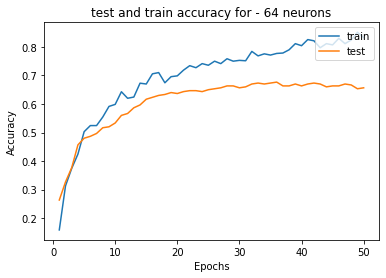

In [44]:
optimal_neurons = 64
print('Model for optimal neurons ',optimal_neurons)
tf.keras.backend.clear_session()
model=build_model(total_classes,input_shape,optimal_neurons)
time_callback = TimeHistory()
history['optimal_neuron_model'] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size,[time_callback])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('test and train accuracy for - '+str(optimal_neurons)+' neurons')
plt.plot(epoch_list,history['optimal_neuron_model'].history['accuracy'],label='train accuracy')
plt.plot(epoch_list,history['optimal_neuron_model'].history['val_accuracy'],label='test accuracy')
plt.legend(['train','test'] , loc='upper right')


#Question-4

In [45]:
total_classes=10
image_shape=X_train[0].shape
hidden_layers=2
history={}
batch_size=1
model=build_model(total_classes,image_shape,optimal_neurons,hidden_layers)
history['question-4']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


700/700 [==============================] - 2s 2ms/step - loss: 1.9076 - accuracy: 0.3200 - val_loss: 1.4265 - val_accuracy: 0.5067
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.4213 - accuracy: 0.4929 - val_loss: 1.2715 - val_accuracy: 0.5367
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.2024 - accuracy: 0.5643 - val_loss: 1.1150 - val_accuracy: 0.6067
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 1.1189 - accuracy: 0.5971 - val_loss: 1.1048 - val_accuracy: 0.6067
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 1.0056 - accuracy: 0.6157 - val_loss: 1.0221 - val_accuracy: 0.6167
Epoch 6/50
700/700 [==============================] - 1s 2ms/step - loss: 0.9447 - accuracy: 0.6743 - val_loss: 0.9893 - val_accuracy: 0.6267
Epoch 7/50
700/700 [==============================] - 1s 2ms/step - loss: 0.8283 - accuracy: 0.7143 - val_loss: 0.9385 - val_accuracy: 0.6533
Epoch 8/50
700/70

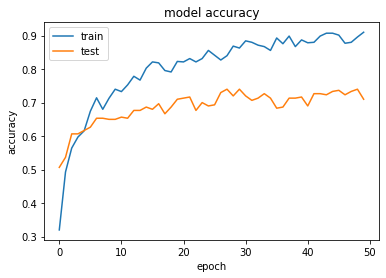

In [46]:
plt.plot(history['question-4'].history['accuracy'])
plt.plot(history['question-4'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Question-5


In [47]:
history={}
model=build_model(10,X_train[0].shape)
hidden_layer_neurons=16
hidden_layers=1
epochs=50
total_classes=10
need_drop_out=False
input_shape=X_train[0].shape
batch_size=1
model=build_model(total_classes,input_shape,hidden_layer_neurons,hidden_layers,need_drop_out)
history={}
history['question-5']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


700/700 [==============================] - 2s 2ms/step - loss: 2.0478 - accuracy: 0.2614 - val_loss: 1.6905 - val_accuracy: 0.3800
Epoch 2/50
700/700 [==============================] - 1s 1ms/step - loss: 1.4215 - accuracy: 0.4929 - val_loss: 1.4201 - val_accuracy: 0.4833
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.1733 - accuracy: 0.6029 - val_loss: 1.2855 - val_accuracy: 0.5500
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 1.0099 - accuracy: 0.6700 - val_loss: 1.2109 - val_accuracy: 0.5700
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 0.8948 - accuracy: 0.7100 - val_loss: 1.1478 - val_accuracy: 0.5900
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 0.8070 - accuracy: 0.7386 - val_loss: 1.1264 - val_accuracy: 0.6033
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 0.7360 - accuracy: 0.7614 - val_loss: 1.1173 - val_accuracy: 0.6000
Epoch 8/50
700/70

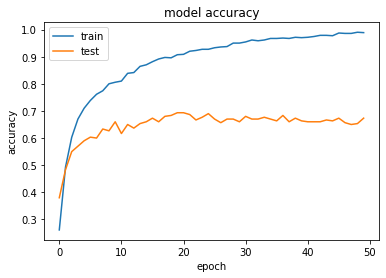

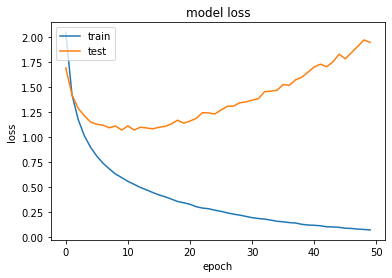

In [48]:
plt.plot(history['question-5'].history['accuracy'])
plt.plot(history['question-5'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['question-5'].history['loss'])
plt.plot(history['question-5'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()